# LoanTap Business Case

## Objective:
To determine the creditworthiness
of potential borrowers using
various attributes, to ensure that
the loans are given to those
who are most likely to repay
them

### Importing libraries

In [87]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, QuantileTransformer, StandardScaler
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import re
import numpy as np
from scipy.stats import skew
from scipy.stats import zscore
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score, precision_recall_curve, auc, average_precision_score
from sklearn.impute import KNNImputer
from imblearn.under_sampling import NearMiss

In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
df = pd.read_csv('/content/drive/My Drive/Documents/DataScience/logistic_regression.csv')
df = pd.DataFrame(df)

In [90]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [91]:
df.shape

(396030, 27)

***Insights:***
The dataset contains 396030 rows and 26 features.

In [92]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',
       'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'application_type',
       'mort_acc', 'pub_rec_bankruptcies', 'address'],
      dtype='object')

In [93]:
df['loan_status'].value_counts(normalize=True)

,proportion
loan_status,
Fully Paid,0.803871
Charged Off,0.196129


The target variable ('loan_status') has a disproportionate number of instances for one class (likely 'Fully Paid') compared to the other ('Charged Off'). This is a common issue in classification problems.

Training a model on imbalanced data can lead to a biased model that performs poorly, especially in predicting the minority class. The model might become too good at predicting the majority class and simply overlook the minority class, which is often the class of interest (e.g., identifying potential loan defaults).

There are two main approaches to address imbalanced datasets:

**1. Oversampling**

**2. Undersampling**

Let's evaluate these two approaches and select the most suitable one.


### Checking the datatype of each attribute

In [94]:
df.dtypes

,0
loan_amnt,float64
term,object
int_rate,float64
installment,float64
grade,object
sub_grade,object
emp_title,object
emp_length,object
home_ownership,object
annual_inc,float64


### Segregating categorical columns and numerical columns.

In [95]:
categorical_columns = df.select_dtypes(include='object').columns
numerical_columns = df.select_dtypes(include = 'float64').columns

In [96]:
categorical_columns

Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'title', 'earliest_cr_line', 'initial_list_status',
       'application_type', 'address'],
      dtype='object')

In [97]:
numerical_columns

Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc',
       'pub_rec_bankruptcies'],
      dtype='object')

In [98]:
data = df.copy()

In [99]:
df[numerical_columns].isnull().sum()

,0
loan_amnt,0
int_rate,0
installment,0
annual_inc,0
dti,0
open_acc,0
pub_rec,0
revol_bal,0
revol_util,276
total_acc,0


### Null values treatment

In [100]:
data.isnull().sum()

,0
loan_amnt,0
term,0
int_rate,0
installment,0
grade,0
sub_grade,0
emp_title,22927
emp_length,18301
home_ownership,0
annual_inc,0


In [101]:
# To extract numerical value from emp_length column.
def extract_numerical_emp_length(emp_length):
  if pd.isnull(emp_length):
    return None
  elif emp_length == '< 1 year':
    return 0
  elif emp_length == '10+ years':
    return 10
  else:
    return float(emp_length.split()[0])

In [102]:
data['emp_length'] = data['emp_length'].apply(extract_numerical_emp_length)

### Imputation of Null values in numerical columns

In [103]:
imputer = KNNImputer(n_neighbors=5) # Using KNN imputer to impute null values.
data[numerical_columns] = imputer.fit_transform(data[numerical_columns])

In [104]:
data[numerical_columns].isnull().sum()

,0
loan_amnt,0
int_rate,0
installment,0
annual_inc,0
dti,0
open_acc,0
pub_rec,0
revol_bal,0
revol_util,0
total_acc,0


### Imputation of Null values in Categorical columns

In [105]:
data['emp_length'] = data['emp_length'].fillna(data['emp_length'].mean())
data['title'] = data['title'].fillna('Unavailable')
data['emp_title'] = data['emp_title'].fillna('Unavailable')

## Feature Engineering

In [106]:
data.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',
       'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'application_type',
       'mort_acc', 'pub_rec_bankruptcies', 'address'],
      dtype='object')

In [107]:
data[['issue_month', 'issue_year']] = data['issue_d'].str.split('-', expand=True) # Creating month and year columns by splitting issue date.
data.drop(['issue_d'], axis=1, inplace=True)

In [108]:
data[['er_cr_line_m', 'er_cr_line_y']] = data['earliest_cr_line'].str.split('-', expand=True)
data.drop(['earliest_cr_line'], axis=1, inplace=True)

In [109]:
data[['state','zipcode']] = data['address'].str.extract(r'([A-Z]{2}) (\d{5})') # Extracting state and zipcode from address column.
data.drop(['address'], axis=1, inplace=True)

In [110]:
data['mort_acc'] = data['mort_acc'].apply(lambda x: 1 if x > 0 else 0)
data['pub_rec'] = data['pub_rec'].apply(lambda x: 1 if x > 0 else 0)
data['pub_rec_bankruptcies'] = data['pub_rec_bankruptcies'].apply(lambda x: 1 if x > 0 else 0)

## Encoding of Categorical columns

In [111]:
encoder = LabelEncoder()

In [112]:
contigency_table = pd.crosstab(data['grade'], data['loan_status'])
chi2_contingency(contigency_table)

Chi2ContingencyResult(statistic=26338.05812796618, pvalue=0.0, dof=6, expected_freq=array([[12588.93733051, 51598.06266949],
       [22754.50373457, 93263.49626543],
       [20787.13292175, 85199.86707825],
       [12458.90374972, 51065.09625028],
       [ 6175.71250663, 25312.28749337],
       [ 2308.83154306,  9463.16845694],
       [  598.97821377,  2455.02178623]]))

**Insights**
From statistical analysis, it is proven that there is high correlation between grade and loan_status

In [113]:
contigency_table = pd.crosstab(data['sub_grade'], data['loan_status'])
chi2_contingency(contigency_table)

Chi2ContingencyResult(statistic=27560.204016877127, pvalue=0.0, dof=34, expected_freq=array([[ 1908.13983032,  7820.86016968],
       [ 1876.36691917,  7690.63308083],
       [ 2074.26116203,  8501.73883797],
       [ 3096.68206197, 12692.31793803],
       [ 3633.48735702, 14892.51264298],
       [ 3762.14803424, 15419.85196576],
       [ 4411.92368002, 18083.07631998],
       [ 5227.82065753, 21427.17934247],
       [ 5021.10060601, 20579.89939399],
       [ 4331.51075676, 17753.48924324],
       [ 4640.8063177 , 19021.1936823 ],
       [ 4428.59465192, 18151.40534808],
       [ 4162.05523066, 17058.94476934],
       [ 3977.49776532, 16302.50223468],
       [ 3578.17895614, 14665.82104386],
       [ 3136.69239452, 12856.30760548],
       [ 2736.19681085, 11214.80318915],
       [ 2397.28575865,  9825.71424135],
       [ 2286.27669873,  9370.72330127],
       [ 1902.45208696,  7797.54791304],
       [ 1552.75393531,  6364.24606469],
       [ 1457.43520188,  5973.56479812],
       [ 121

### Label encoding of grade and sub_grade columns

In [114]:
data['grade'] = encoder.fit_transform(data['grade'])
data['sub_grade'] = encoder.fit_transform(data['sub_grade'])

**Insights:**
The loan status depends somewhat on the grade and subgrade columns. As I understand it, Loan Tap assigns grades and subgrades based on the debtor's creditworthiness.

### Perform one hot encoding on all the relevant categorical columns

In [115]:
categorical_col = ['term', 'home_ownership', 'verification_status', 'application_type', 'issue_month', 'issue_year', 'purpose', 'emp_title', 'initial_list_status', 'er_cr_line_y', 'zipcode', 'state']

In [116]:
for col in categorical_col:
  contigency_table = pd.crosstab(data[col], data['loan_status'])
  statistic, pvalue, dof, expected = chi2_contingency(contigency_table)
  print(f'pvalue of {col} is {pvalue}')

pvalue of term is 0.0
pvalue of home_ownership is 0.0
pvalue of verification_status is 0.0
pvalue of application_type is 1.1418557766942247e-13
pvalue of issue_month is 9.980952577399617e-43
pvalue of issue_year is 0.0
pvalue of purpose is 6.573354783158025e-291
pvalue of emp_title is 0.1286635982489766
pvalue of initial_list_status is 2.408916483118551e-09
pvalue of er_cr_line_y is 6.10476618638809e-198
pvalue of zipcode is 0.0
pvalue of state is 0.6495028321544145


In [117]:
data['initial_list_status'] = data['initial_list_status'].apply(lambda x: 1 if x == 'w' else 0)
data['term'] = data['term'].apply(lambda x: 1 if x == ' 36 months' else 0)
data['loan_status'] = data['loan_status'].apply(lambda x: 0 if x == 'Fully Paid' else 1)

In [118]:
df_encoded = pd.get_dummies(data, columns=['home_ownership', 'verification_status', 'application_type', 'issue_month', 'issue_year', 'purpose',  'zipcode']) * 1
df_encoded.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,annual_inc,loan_status,...,zipcode_00813,zipcode_05113,zipcode_11650,zipcode_22690,zipcode_29597,zipcode_30723,zipcode_48052,zipcode_70466,zipcode_86630,zipcode_93700
0,10000.0,1,11.44,329.48,1,8,Marketing,10.0,117000.0,0,...,0,0,0,1,0,0,0,0,0,0
1,8000.0,1,11.99,265.68,1,9,Credit analyst,4.0,65000.0,0,...,0,1,0,0,0,0,0,0,0,0
2,15600.0,1,10.49,506.97,1,7,Statistician,0.0,43057.0,0,...,0,1,0,0,0,0,0,0,0,0
3,7200.0,1,6.49,220.65,0,1,Client Advocate,6.0,54000.0,0,...,1,0,0,0,0,0,0,0,0,0
4,24375.0,0,17.27,609.33,2,14,Destiny Management Inc.,9.0,55000.0,1,...,0,0,1,0,0,0,0,0,0,0


In [119]:
df_encoded.drop(['emp_title', 'title', 'state', 'er_cr_line_m', 'er_cr_line_y'], axis=1, inplace=True)

In [120]:
df_encoded.shape

(396030, 76)

In [121]:
df_encoded.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_length', 'annual_inc', 'loan_status', 'dti', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
       'mort_acc', 'pub_rec_bankruptcies', 'home_ownership_ANY',
       'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'application_type_DIRECT_PAY', 'application_type_INDIVIDUAL',
       'application_type_JOINT', 'issue_month_Apr', 'issue_month_Aug',
       'issue_month_Dec', 'issue_month_Feb', 'issue_month_Jan',
       'issue_month_Jul', 'issue_month_Jun', 'issue_month_Mar',
       'issue_month_May', 'issue_month_Nov', 'issue_month_Oct',
       'issue_month_Sep', 'issue_year_2007', 'issue_year_2008',
       'issue_year_2009', 'issue_year_2010', 'issue_year_2

## Outlier treatment of Numerical columns

In [122]:
numerical_columns

Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc',
       'pub_rec_bankruptcies'],
      dtype='object')

In [123]:
numerical_columns = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc', 'revol_bal', 'revol_util']

In [124]:
df_encoded.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,annual_inc,loan_status,dti,...,zipcode_00813,zipcode_05113,zipcode_11650,zipcode_22690,zipcode_29597,zipcode_30723,zipcode_48052,zipcode_70466,zipcode_86630,zipcode_93700
0,10000.0,1,11.44,329.48,1,8,10.0,117000.0,0,26.24,...,0,0,0,1,0,0,0,0,0,0
1,8000.0,1,11.99,265.68,1,9,4.0,65000.0,0,22.05,...,0,1,0,0,0,0,0,0,0,0
2,15600.0,1,10.49,506.97,1,7,0.0,43057.0,0,12.79,...,0,1,0,0,0,0,0,0,0,0
3,7200.0,1,6.49,220.65,0,1,6.0,54000.0,0,2.60,...,1,0,0,0,0,0,0,0,0,0
4,24375.0,0,17.27,609.33,2,14,9.0,55000.0,1,33.95,...,0,0,1,0,0,0,0,0,0,0


### Visualizing outliers using boxplot

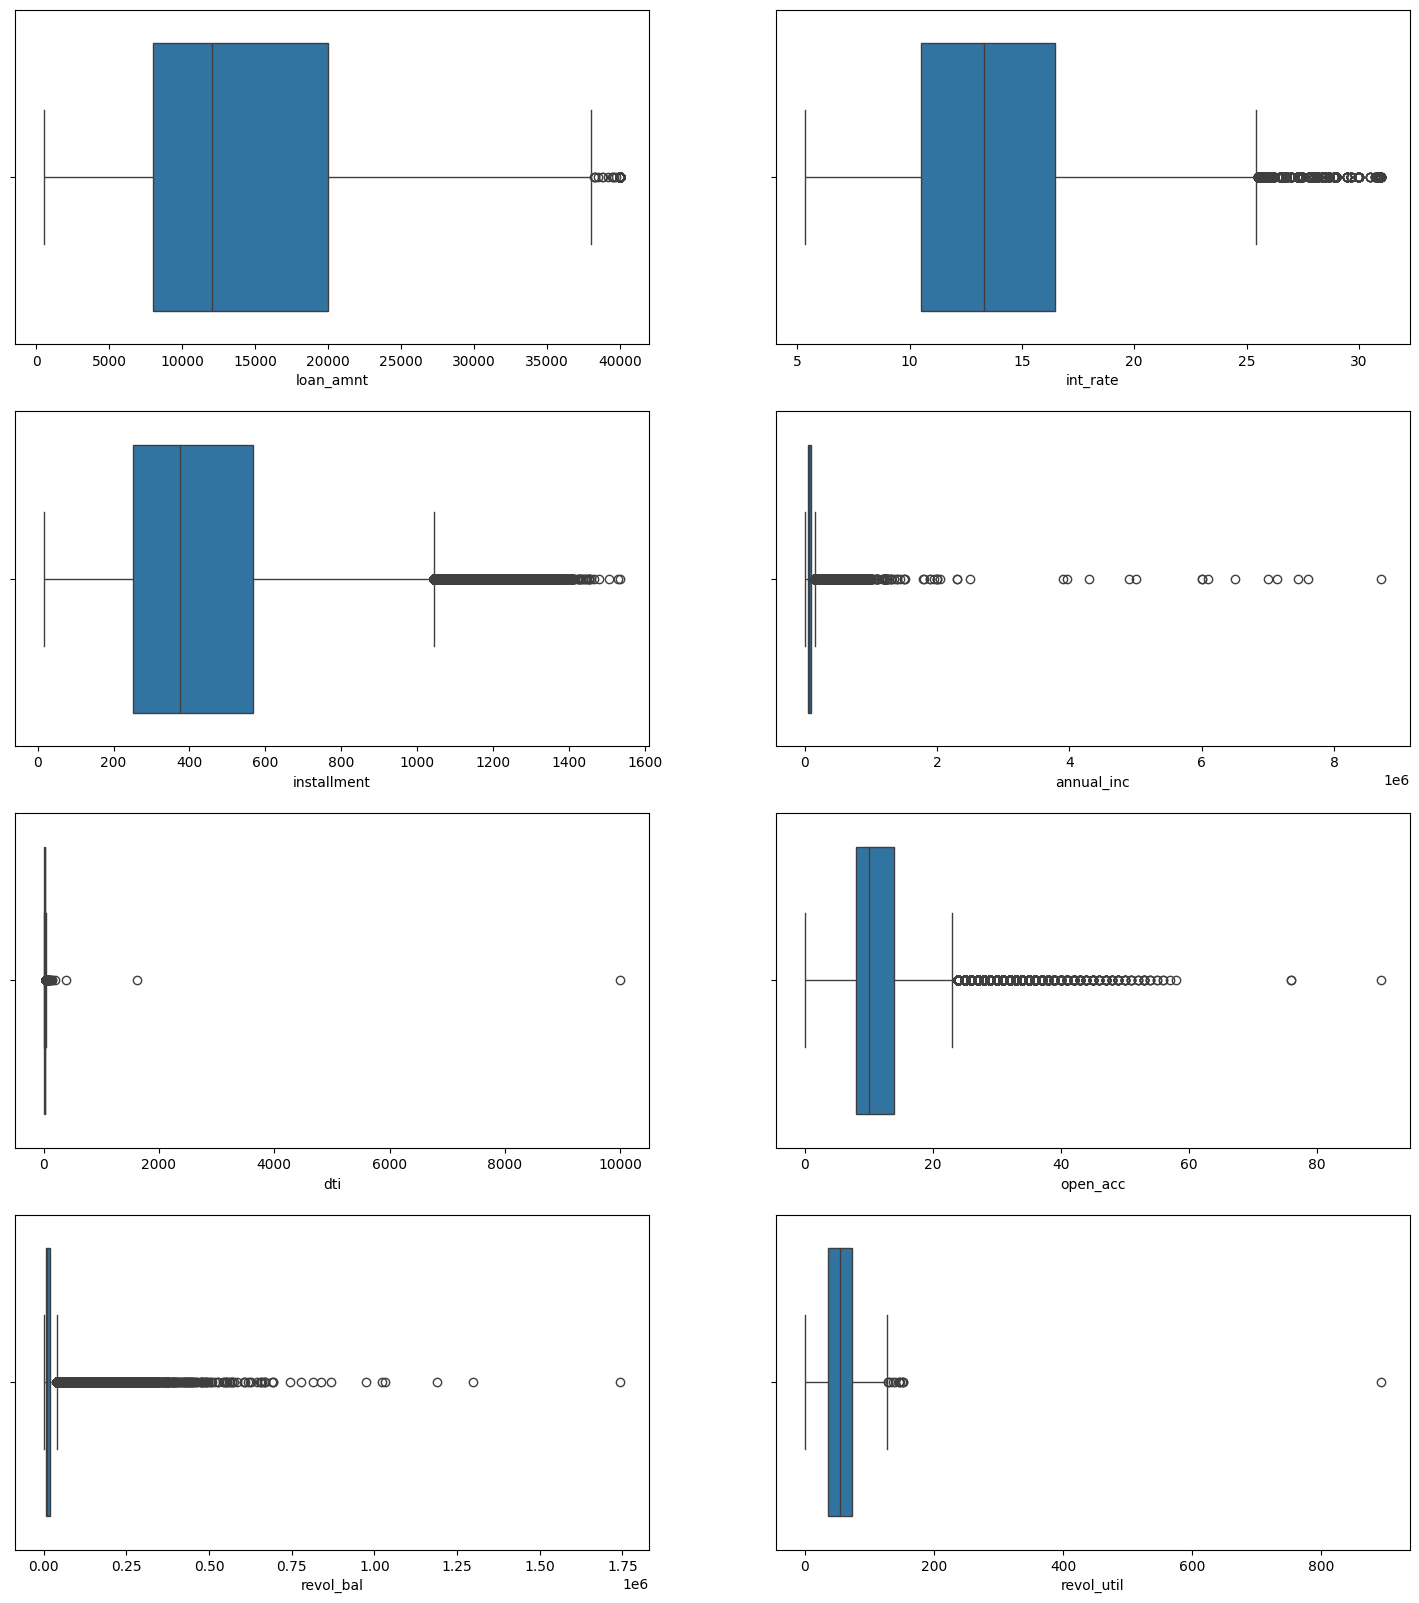

In [125]:
num_plots = len(numerical_columns)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))
axes = axes.flatten()
for i, col in enumerate(numerical_columns):
  sns.boxplot(x = col, data = df_encoded, ax = axes[i])

plt.show()

**Insights:**  
The data reveals the presence of outliers.

In [126]:
skewness = df_encoded[numerical_columns].skew()
skewness

,0
loan_amnt,0.777285
int_rate,0.420669
installment,0.983598
annual_inc,41.042725
dti,431.051225
open_acc,1.213019
revol_bal,11.727515
revol_util,-0.072557


### Visualizing the skewness of data

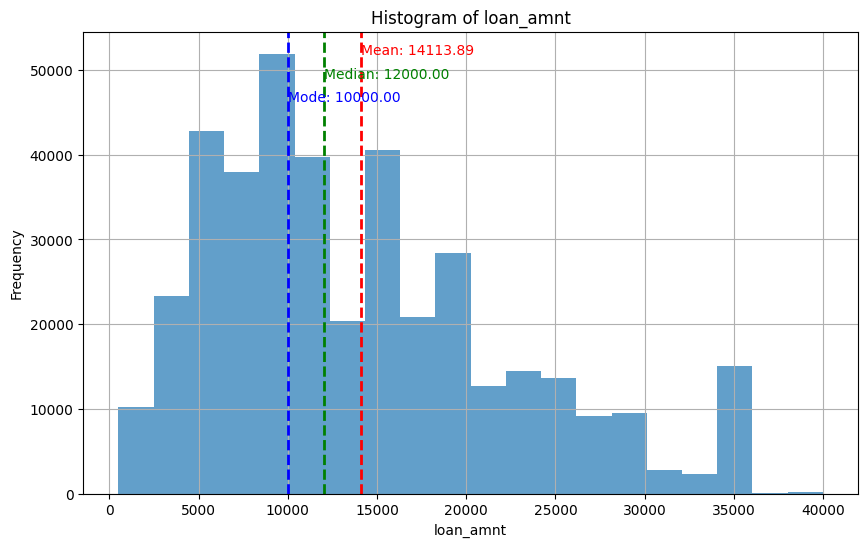

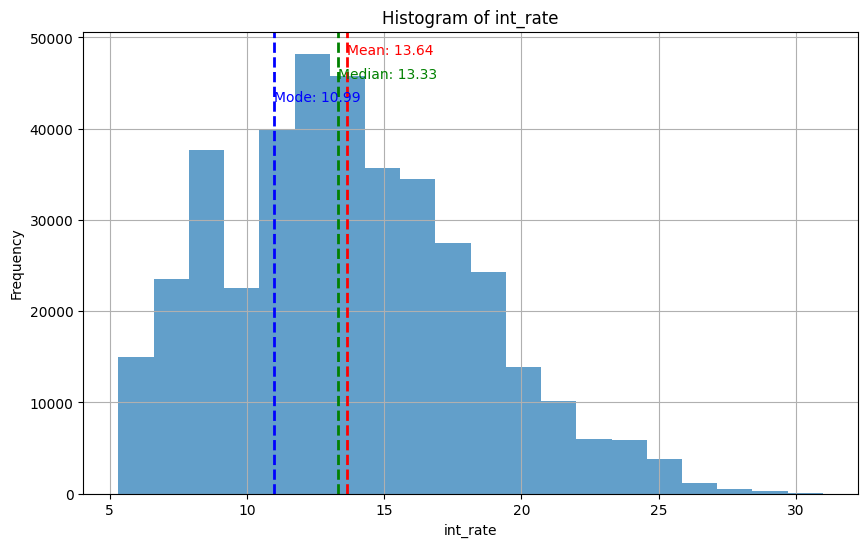

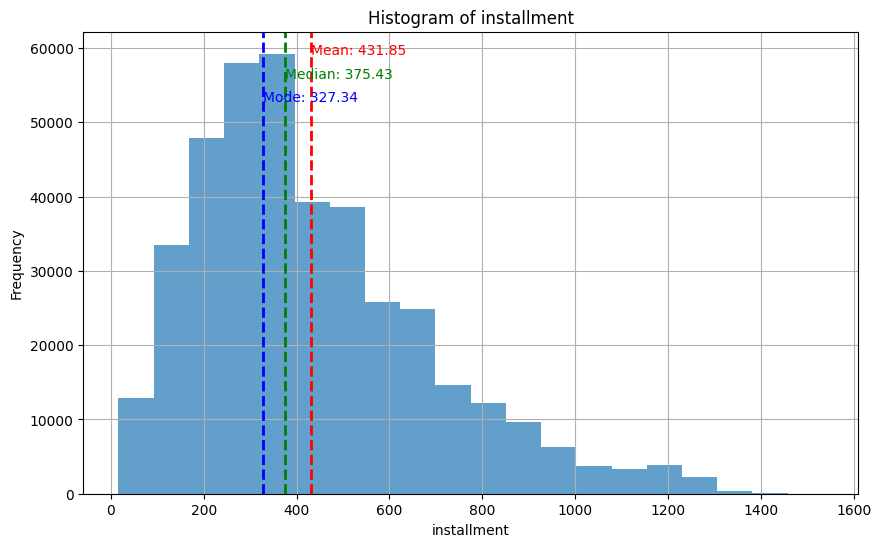

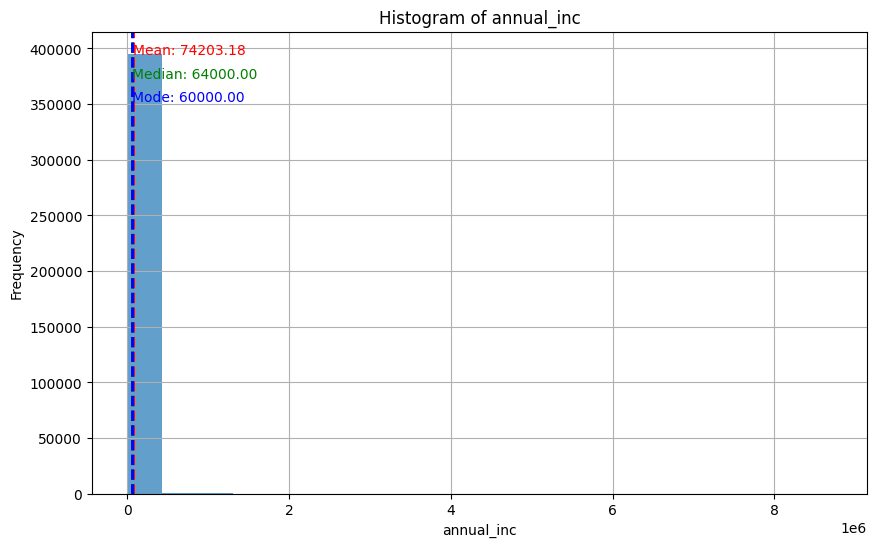

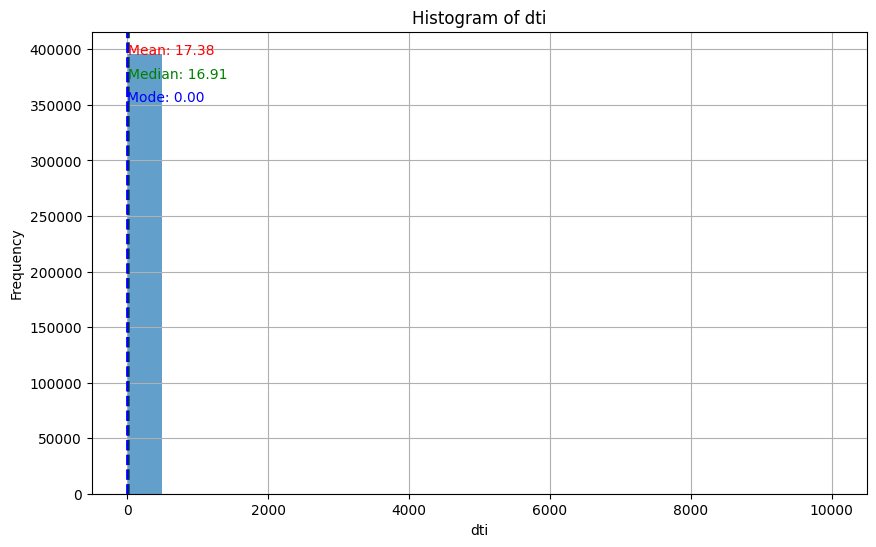

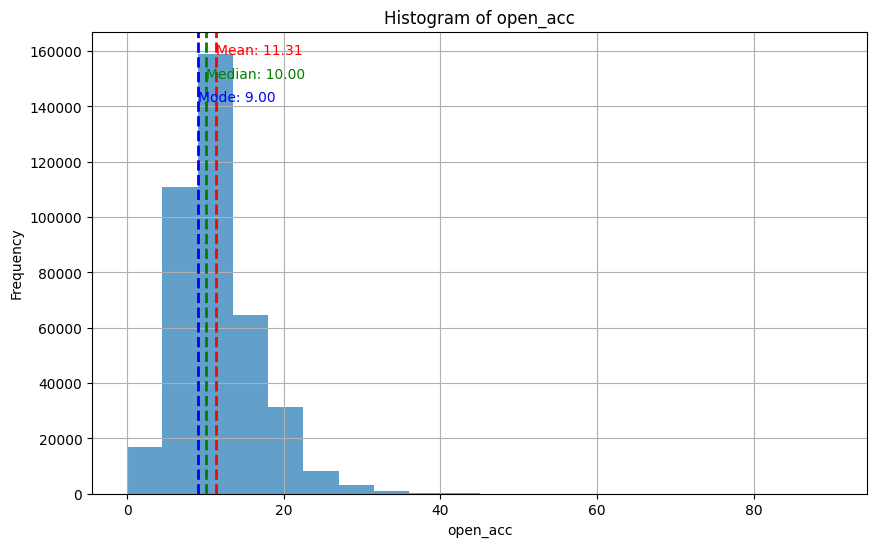

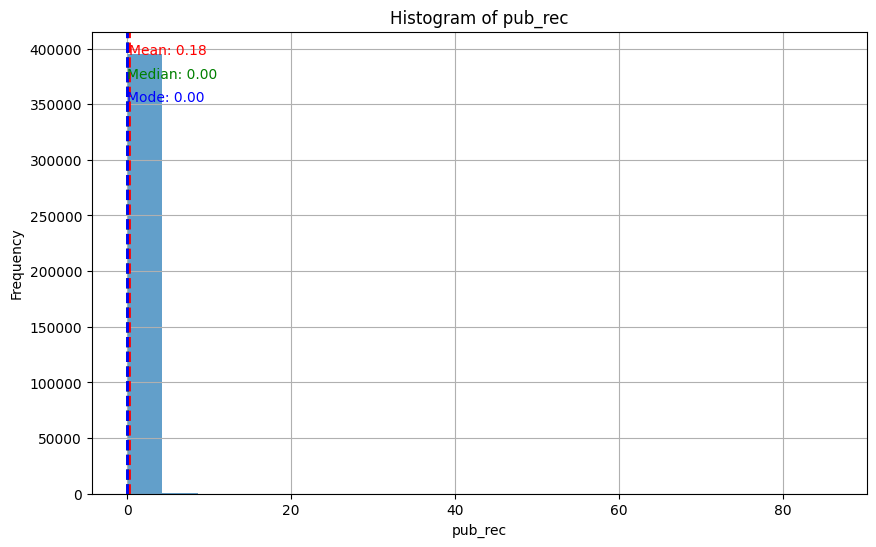

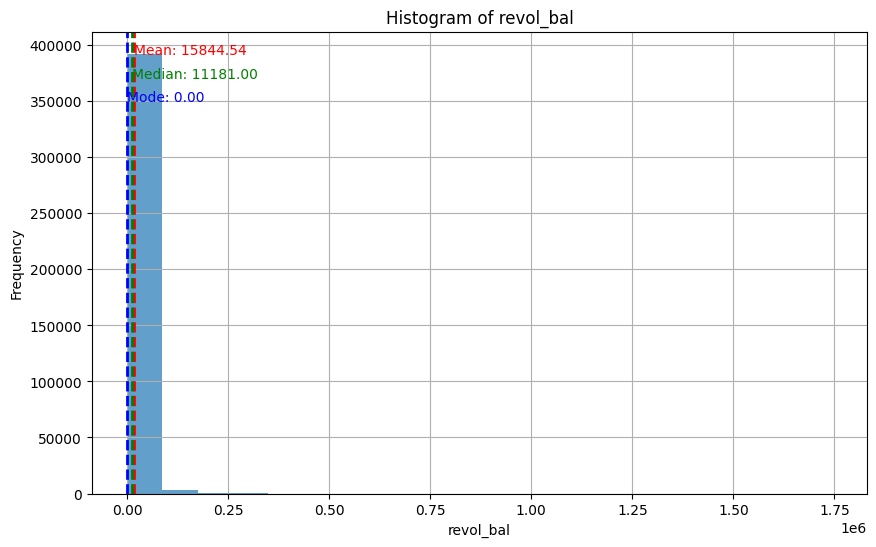

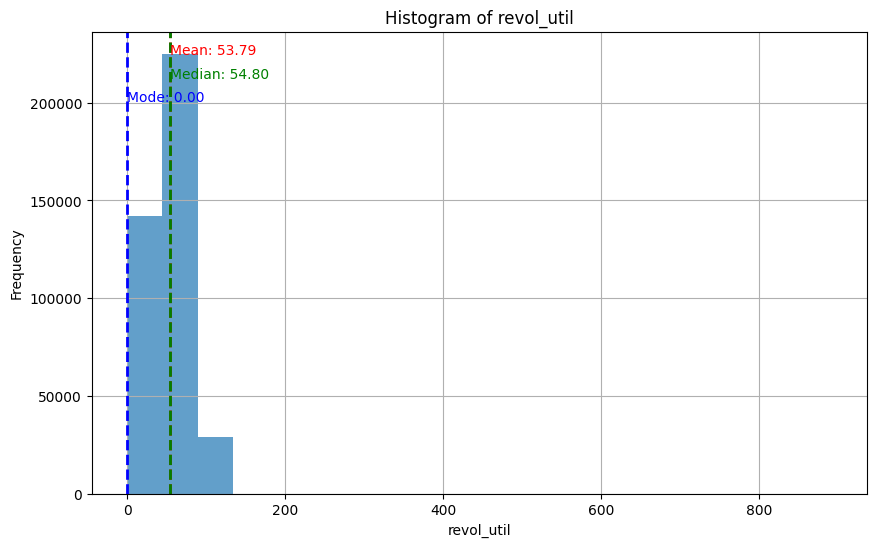

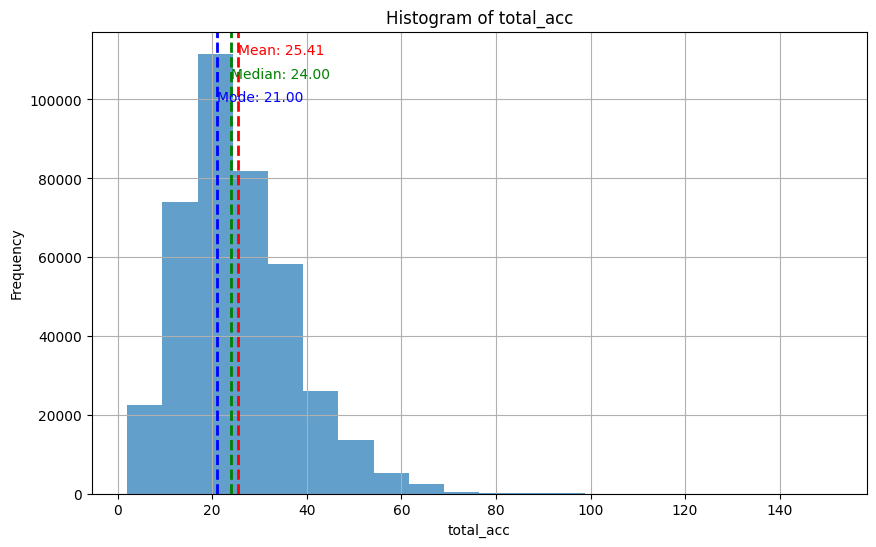

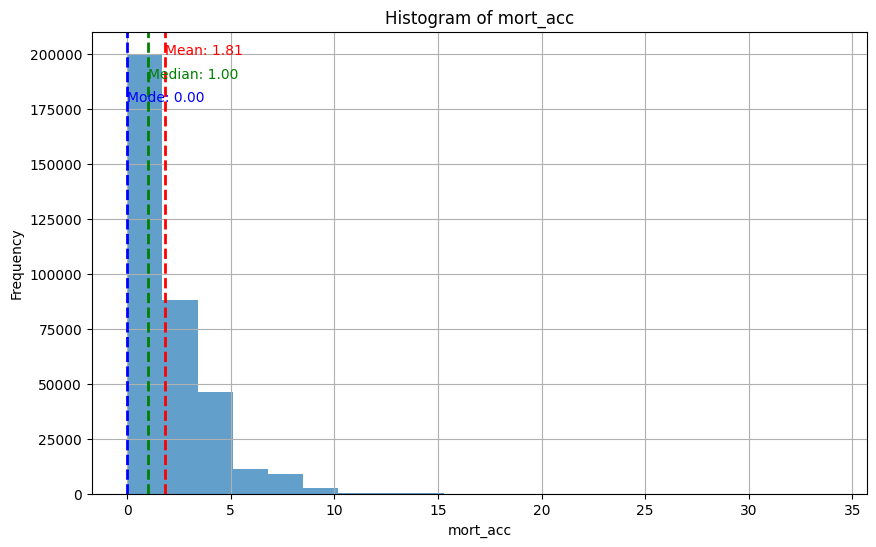

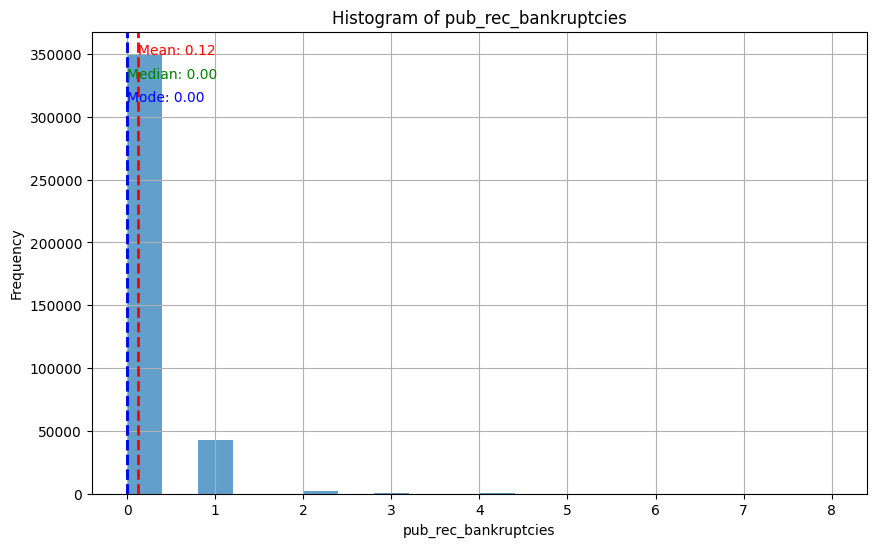

In [127]:
for feature in df.columns:
    # Skipping non-numeric features for histogram plotting
    if df[feature].dtype == "object":
        continue

    # Calculate mean, median, and mode
    mean = df[feature].mean()
    median = df[feature].median()
    mode = df[feature].mode().get(0, np.nan)
    plt.figure(figsize=(10, 6))
    df[feature].hist(bins=20, alpha=0.7)

    # Add lines for mean, median, and mode
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=2)
    plt.axvline(median, color='green', linestyle='dashed', linewidth=2)
    plt.axvline(mode, color='blue', linestyle='dashed', linewidth=2)

    # Add annotations for mean, median, and mode
    plt.text(mean, plt.ylim()[1] * 0.95, f'Mean: {mean:.2f}', color = 'red')
    plt.text(median, plt.ylim()[1] * 0.90, f'Median: {median:.2f}', color = 'green')
    plt.text(mode, plt.ylim()[1] * 0.85, f'Mode: {mode:.2f}', color = 'blue')

    # Add title and labels
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()

**Insights:**
Visualizations indicate that most features are right-skewed. Therefore, a quantile transformer is applied to mitigate data skewness.



In [128]:
qt = QuantileTransformer(output_distribution='normal') # Applying quantile transformation to the numerical features to mitigate skewness
df_encoded[numerical_columns] = qt.fit_transform(df_encoded[numerical_columns])

In [129]:
skewness = df_encoded[numerical_columns].skew()
skewness

,0
loan_amnt,-0.368076
int_rate,-0.533982
installment,-0.004173
annual_inc,-0.023940
dti,-0.045865
open_acc,0.043875
revol_bal,-0.521718
revol_util,-0.510033


In [130]:
df_encoded['loan_status'].value_counts(normalize = True)

,proportion
loan_status,
0,0.803871
1,0.196129


In [131]:
# Calculating z score for numerical columns.
z = np.abs(zscore(df_encoded[numerical_columns]))

In [132]:
# Now removing all data points for which z score is greater than 2.5
data_no_outliers = df_encoded[(z <= 3).all(axis=1)]

In [133]:
# Checking the shape of the dataset after removing outliers.
data_no_outliers.shape

(386015, 76)

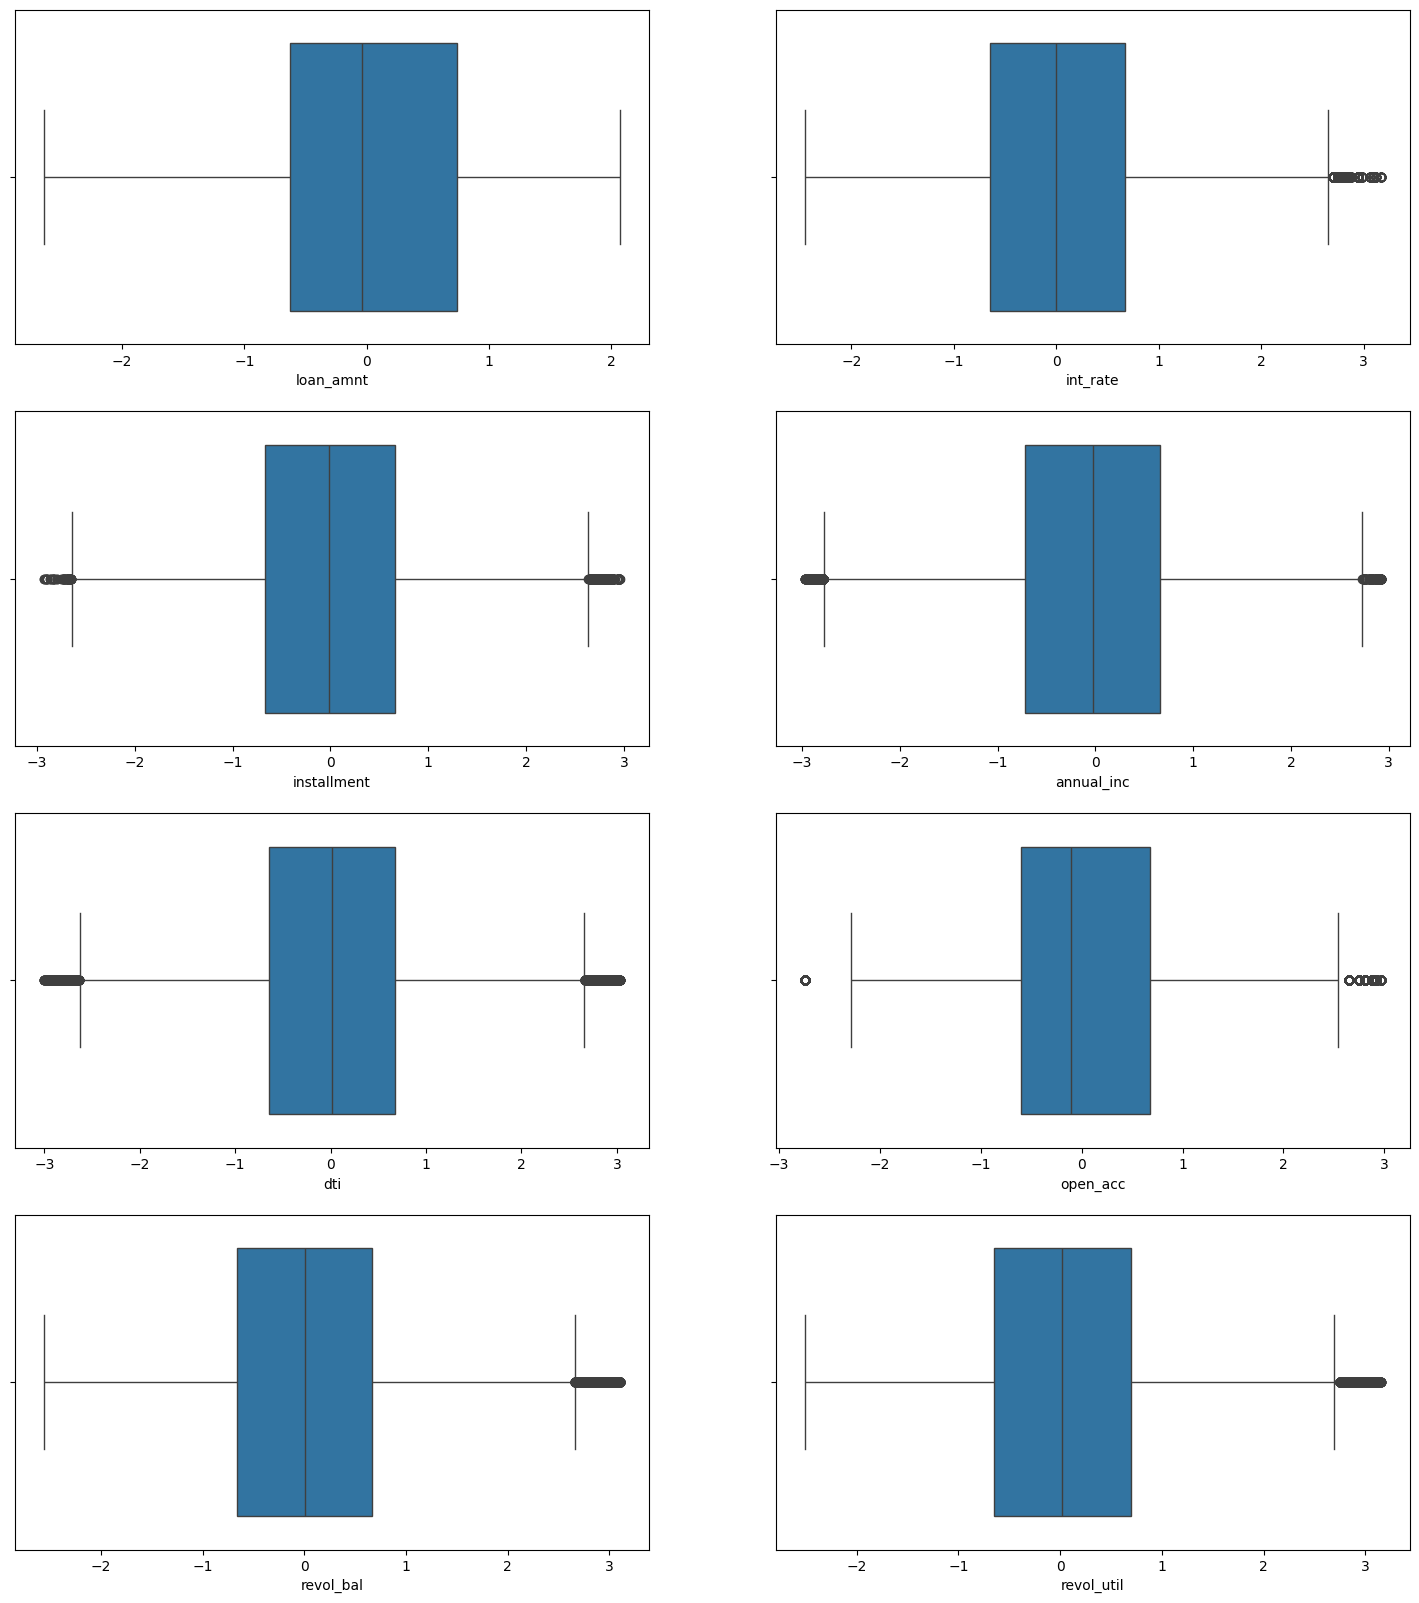

In [134]:
# Rechecking the presence of outliers using boxplot.
num_plots = len(numerical_columns)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))
axes = axes.flatten()
for i, col in enumerate(numerical_columns):
  sns.boxplot(x = col, data = data_no_outliers, ax = axes[i])

plt.show()

In [135]:
data_no_outliers['loan_status'].value_counts(normalize=True)

,proportion
loan_status,
0,0.80301
1,0.19699


**Note:**
Notice how imbalanced is our original dataset! Most of the customers are fully-paid. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most customers are fully paid. But we don't want our model to assume, we want our model to detect patterns that give signs of charged off

Text(0.5, 1.0, 'Class Distributions \n (0: Charged Off || 1: Fully paid)')

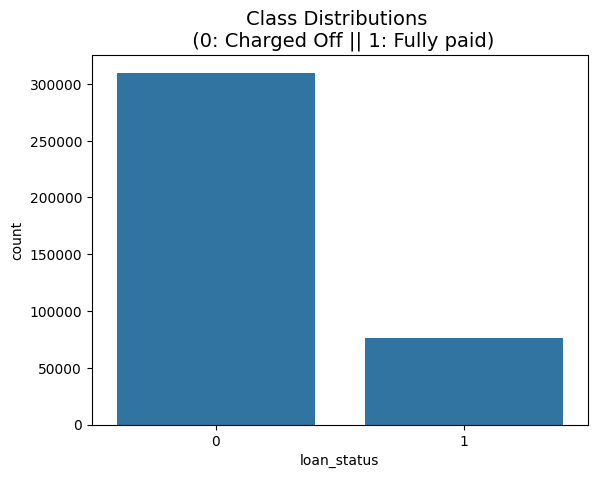

In [136]:
sns.countplot(data=data_no_outliers, x='loan_status')
plt.title('Class Distributions \n (0: Charged Off || 1: Fully paid)', fontsize=14)

## Implementation of model

### Separating features and target variables

In [137]:
X = data_no_outliers.drop('loan_status', axis=1)
y = data_no_outliers['loan_status']

In [138]:
y.value_counts(normalize=True)

,proportion
loan_status,
0,0.80301
1,0.19699


### Splitting data into train, validation and test data sets

In [139]:
X_train_cv, X_test, y_train_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [140]:
X_train_cv.shape, X_test.shape, y_train_cv.shape, y_test.shape

((308812, 75), (77203, 75), (308812,), (77203,))

In [141]:
X_train, X_cv, y_train, y_cv = train_test_split(X_train_cv, y_train_cv, test_size=0.2, random_state=42)

In [142]:
X_train.shape, X_cv.shape, y_train.shape, y_cv.shape

((247049, 75), (61763, 75), (247049,), (61763,))

In [143]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_cv_scaled = scaler.transform(X_cv)
X_test_scaled = scaler.transform(X_test)

### Different ways of working on imbalance dataset

In [144]:
model_class_weight = LogisticRegression(class_weight='balanced', max_iter=200)
model_class_weight.fit(X_train_scaled, y_train)
y_pred_class_weight = model_class_weight.predict(X_cv_scaled)
report_class_weight = classification_report(y_cv, y_pred_class_weight)
print(report_class_weight)

              precision    recall  f1-score   support

           0       0.94      0.81      0.87     49654
           1       0.50      0.80      0.62     12109

    accuracy                           0.81     61763
   macro avg       0.72      0.81      0.74     61763
weighted avg       0.86      0.81      0.82     61763



In [145]:
model_weight = LogisticRegression(class_weight={0: 1, 1: 2})
model_weight.fit(X_train_scaled, y_train)
y_pred_weight = model_weight.predict(X_cv_scaled)
report_class_weight = classification_report(y_cv, y_pred_class_weight)
print(report_class_weight)

              precision    recall  f1-score   support

           0       0.94      0.81      0.87     49654
           1       0.50      0.80      0.62     12109

    accuracy                           0.81     61763
   macro avg       0.72      0.81      0.74     61763
weighted avg       0.86      0.81      0.82     61763



### Oversampling the minority class using SMOTE

In [146]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [147]:
scaler.fit(X_train_resampled)
X_train_resampled_scaled = scaler.transform(X_train_resampled)
X_cv_scaled_smote_scaled = scaler.transform(X_cv)
X_test_scaled_smote = scaler.transform(X_test)

In [159]:
model_smote = LogisticRegression()
model_smote.fit(X_train_resampled_scaled, y_train_resampled)
y_pred_smote = model_smote.predict(X_cv_scaled_smote_scaled)
report_smote = classification_report(y_cv, y_pred_smote)
print(report_smote)

              precision    recall  f1-score   support

           0       0.89      0.99      0.93     49654
           1       0.91      0.48      0.63     12109

    accuracy                           0.89     61763
   macro avg       0.90      0.73      0.78     61763
weighted avg       0.89      0.89      0.87     61763



### Observations:
SMOTE outperformed the other methods, likely due to its ability to create synthetic data points for the 'Charged Off' class, providing the model with more information to learn about this crucial class. This improved representation likely led to better predictions compared to relying on class weights to bias the training process.


### Precision recall curve

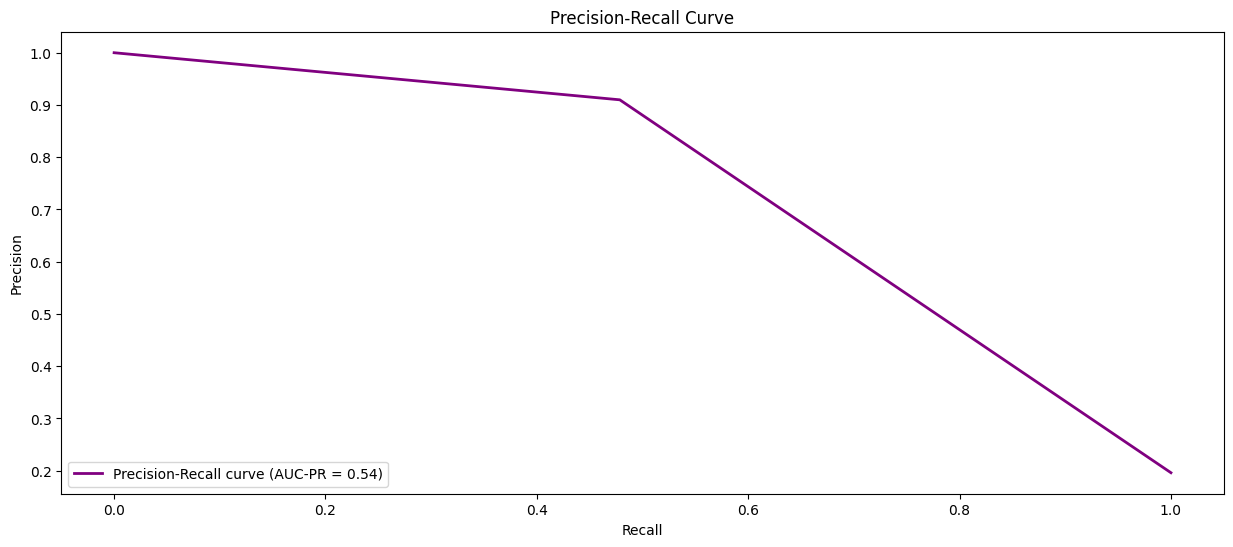

In [149]:
precision, recall, threshold = precision_recall_curve(y_cv, y_pred_smote)
auc_score = auc(recall, precision).round(3)
average_precision = average_precision_score(y_cv, y_pred_smote)
plt.figure(figsize=(15, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f'Precision-Recall curve (AUC-PR = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


### Observations:
1. The curve shows a decent trade-off between precision and recall.
2. There is a point on the curve where precision and recall are roughly balanced, around the middle of the plot.
3. The choice of the optimal threshold will be determined by the priority of LoanTap's business goals regarding False positives and recall of true charged-off loans.


**TP or true positive** represents the number of positive class records the model correctly predicts as positive.

**False positive** represents the number of negative class records the model incorrectly predicts as negative.

**True negative** represents the number of negative class records the model correctly predicts as negative.

**False negative** represents the number of positive class records the model incorrectly predicts as negative.






**Insights:**  
1. The precision score is strong for both training and validation data. Among all customers predicted to be fully paid, most of them actually are fully paid.
2. However, the recall for the validation data regarding the minority class is not satisfactory, sitting at around 0.47. This implies that the model can accurately predict only 47% of the charged-off customers.

### ROC-AUC Curve

The ROC curve gives a visual representation of the trade-offs between the true positive rate (TPR) and false positive rate (FPR) at various thresholds. It provides insights into how well the model can balance the trade-offs between detecting positive instances and avoiding false positives across different thresholds.

AUC, or Area Under the Curve, is a single scalar value ranging from 0 to 1,

**True positive rate**
The true positive rate, also known as sensitivity or recall, reflects a model’s ability to correctly identify positive instances. It measures the proportion of actual positive cases that the model successfully identifies. Mathematically, this can be expressed by the following equation:

equation for true positive rate = **TP/(TP + FN)**

**False positive rate**
FPR represents how often our model incorrectly classifies negative class instances as positive. It measures the proportion of actual negative instances that are incorrectly identified as positive by the model, indicating the rate of false alarms. Mathematically this can be expressed as follows.

**FPR = FP/(FP + TN)**

### ROC Curve for all the three models

In [153]:
# Calculating predicted probabilities for class 1
y_pred_prob_cw = model_class_weight.predict_proba(X_cv_scaled)[:, 1]
y_pred_prob_w = model_weight.predict_proba(X_cv_scaled)[:, 1]
y_pred_prob_smote = model_smote.predict_proba(X_cv_scaled_smote_scaled)[:, 1]
# Calculating ROC curve
fpr, tpr, thresholds = roc_curve(y_cv, y_pred_prob_cw)
fpr_w, tpr_w, thresholds_w = roc_curve(y_cv, y_pred_prob_w)
fpr_smote, tpr_smote, thresholds_smote = roc_curve(y_cv, y_pred_prob_smote)
# Calculating AUC Score
auc_score = roc_auc_score(y_cv, y_pred_prob_cw)
auc_score_w = roc_auc_score(y_cv, y_pred_prob_w)
auc_score_smote = roc_auc_score(y_cv, y_pred_prob_smote)

In [154]:
auc_score, auc_score_w, auc_score_smote

(0.9059835610030629, 0.9060011490597601, 0.9059258804929616)

**Insights:**


### Testing the model on test data

In [164]:
y_test_pred = model_smote.predict(X_test_scaled_smote)
model_smote.score(X_test_scaled_smote, y_test)

0.889550924186884

In [165]:
report = classification_report(y_test, y_test_pred)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.99      0.93     61951
           1       0.91      0.49      0.64     15252

    accuracy                           0.89     77203
   macro avg       0.90      0.74      0.79     77203
weighted avg       0.89      0.89      0.88     77203



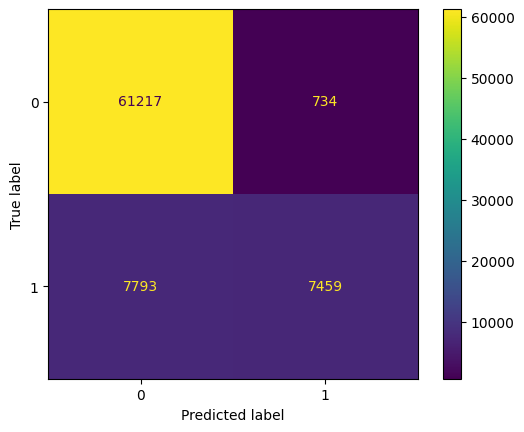

In [166]:
ConfusionMatrixDisplay.from_estimator(model_smote, X_test_scaled_smote , y_test)